In [1]:
import keyring
import os
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

# StateGraph로 상태 만들기

In [ ]:
from typing import TypedDict        # type을 지정해서 dictionary를 설정
from langgraph.graph import StateGraph

class State(TypedDict):
    counter: int
    alphabet: list[str]
    
graph_builder = StateGraph(State)

In [3]:
from typing import Annotated            # Annotated -> metadata 추가
from typing_extensions import TypedDict # typing, typing_extensions 상관없음

from langgraph.graph import StateGraph, START, END
import operator

class State(TypedDict):
    counter: int
    alphabet: list[str]
    
def node_a(state: State):
    # node는 함수형으로 선언하되, State를 입력값으로 받아야 함
    state['counter'] += 1
    state['alphabet'] = ['Hello']
    return state

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", node_a)   # "chatbot"이라는 노드는 node_a라는 함수를 실행

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()     # 그래프 실행 가능 객체로 변환

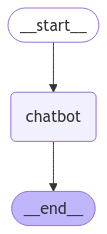

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
# initial state
initial_state = {
    "counter":0,
    "alphabet": []
}

state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello']}
{'counter': 3, 'alphabet': ['Hello']}


In [6]:
class State(TypedDict):
    counter: int 
    alphabet: Annotated[list[str], operator.add]        # list[str]을 입력값으로 받으면 그것을 계속 더한다. operator.add
    
def node_a(state: State):
    state['counter'] += 1
    state['alphabet'] = ['Hello']
    return state

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", node_a)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [7]:
# initial state
initial_state = {
    "counter": 0,
    "alphabet": []
}

state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello', 'Hello']}
{'counter': 3, 'alphabet': ['Hello', 'Hello', 'Hello']}


# Message를 담는 StateGraph

In [8]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages        # message 리스트를 누적

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model='gpt-4o-mini')

def chatbot(state: State):
    return {"messages": [llm.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point('chatbot')
graph_builder.set_finish_point('chatbot')
graph = graph_builder.compile()

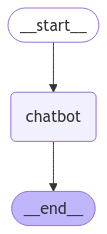

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # this requires some extra dependencies and is optional
    pass

In [10]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        print("User", user_input)
        for value in event.values():
            # print("User", user_input)
            print("Assistant:", value["messages"][-1].content)

User hello
Assistant: Hello! How can I assist you today?
User what year is it now?
Assistant: The current year is 2023.
User are you sure?
Assistant: Yes, I'm trained on data up until October 2023. How can I assist you today?
Goodbye!


In [ ]:
# MessageState 활용
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState       # 기존에 State class와 Annotated[list, add_messages]로 구현했던 부분 래핑된 라이브러리

graph_builder = StateGraph(MessagesState)

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [15]:
while True: 
    user_input = input("User: ")
    if user_input.lower() in ['quit', 'exit', 'q']:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Goodbye!


In [ ]:
# MessageState 추가 변수

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

class State(MessagesState):
    counter: int

graph_builder = StateGraph(State)

llm = ChatOpenAI(model='gpt-4o-mini')

def chatbot(state: State):
    state['counter'] = state.get('counter', 0) + 1      #  counter를 가져와서 없으면 0, 아니면 +1
    return {
        "messages": [llm.invoke(state['messages'])],
        "counter": state['counter']
    }
    
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [17]:
from langchain_core.messages import HumanMessage

# initial state
initial_state = {
    "messages": [HumanMessage(content="Hello!")],
    "counter": 0
}

# execute graph
result = graph.invoke(initial_state)

print(f"Final state: {result}")

Final state: {'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='44b01b7a-f56d-4d70-9415-556181d61bda'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-a749cfe7-ff6c-4b29-bfdb-6fa8d8f96f14-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})], 'counter': 1}


In [18]:
state = initial_state
for _ in range(3):
    state = graph.invoke(state)
    print(f"Counter: {state['counter']}")
    print(f"Last message: {state['messages'][-1].content}")
    print("---")

Counter: 1
Last message: Hello! How can I assist you today?
---
Counter: 2
Last message: Hello! How can I assist you today?
---
Counter: 3
Last message: Hello! How can I assist you today?
---
